In [1]:
import sys
import os
import pathlib
import json
import pyvista as pv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


working_dir = pathlib.Path(os.path.abspath(""))
sys.path.append(str(working_dir.parent))
from runs import find_runs  # noqa: E402

### Load data and calculate error

In [2]:
def load_data(runs_dir: pathlib.Path, timestep: int) -> pd.DataFrame:
    """Load the data from the runs in the given directory. Only load the given timestep.

    Args:
        runs_dir: The directory containing the runs.
        timestep: The timestep to load.

    Return:
        A pandas DataFrame containing the data. The index is the grid spacing and
        the columns are the different mappings.
    """

    # Find the runs, we are interested in
    runs = find_runs(runs_dir)

    # Load the data
    data = {} # Raw data: {column: {grid_spacing: error_value}}

    for run_path in runs:

        # Read parameters of the run
        with open(run_path / "parameters.json") as file:
            parameters = json.load(file) 

        # Generate descriptive column name
        column_name = {
            "nearest-neighbor": "NN",
            "rbf-pum-direct": "RBF",
        }[parameters["mapping"]]

        if parameters["mapping"] == "rbf-pum-direct":
            column_name += (
                "_"
                + {
                    "compact-polynomial-c0": "CP0",
                    "compact-polynomial-c2": "CP2",
                    "compact-polynomial-c4": "CP4",
                    "compact-polynomial-c6": "CP6",
                    "compact-polynomial-c8": "CP8",
                }[parameters["basis_function"]]
            )
            column_name += f"_{parameters['support_radius']}"

        # Calculate grid spacing from refinement level
        grid_spacing = 1 / 2 ** parameters["refinement"]

        # Calculate velocity error
        try:
            file_name = f"refinement-{parameters["refinement"]}_particles_{timestep:06}.pvtu"
            mesh = pv.read(run_path / "solution" / file_name)

            mesh["error"] = np.linalg.norm(mesh["velocity"] - mesh["analytical_velocity"], axis=1)

            mean_error = mesh["error"].mean()
        
        except FileNotFoundError:
            mean_error = np.nan

        # Insert error into data dict
        if column_name not in data:
            data[column_name] = {}
        data[column_name][grid_spacing] = mean_error

    # Convert data dict to pandas DataFrame
    return pd.DataFrame(data).sort_index(axis=0, ascending=False).sort_index(axis=1)

df = load_data(working_dir.parent / "runs" / "euler_explicit_wrong", 250)
df

,NN,RBF_CP0_0.5,RBF_CP2_0.5,RBF_CP4_0.5,RBF_CP6_0.5,RBF_CP8_0.5
1.000000,0.813975,0.813975,0.813975,0.813975,0.813975,0.813975
0.500000,0.813975,0.813975,0.813975,0.813975,0.813975,0.813975
0.250000,0.262370,0.267888,0.128261,0.204689,0.291959,0.372547
0.125000,0.141976,0.043021,0.011157,0.015134,0.018089,0.018398
0.062500,0.066152,0.014062,0.005304,0.005390,0.005412,0.005412
0.031250,0.030744,0.007687,0.005444,0.005436,0.005435,0.005434
0.015625,0.016084,0.005957,0.005437,0.005434,0.005434,0.005434
0.007812,0.008642,0.005557,0.005435,0.005434,0.005434,0.005434
0.003906,0.006405,0.005464,0.005434,0.005434,0.005434,0.005434
0.001953,0.005651,0.005441,0.005434,0.005434,0.005434,NaN


### Plot the error

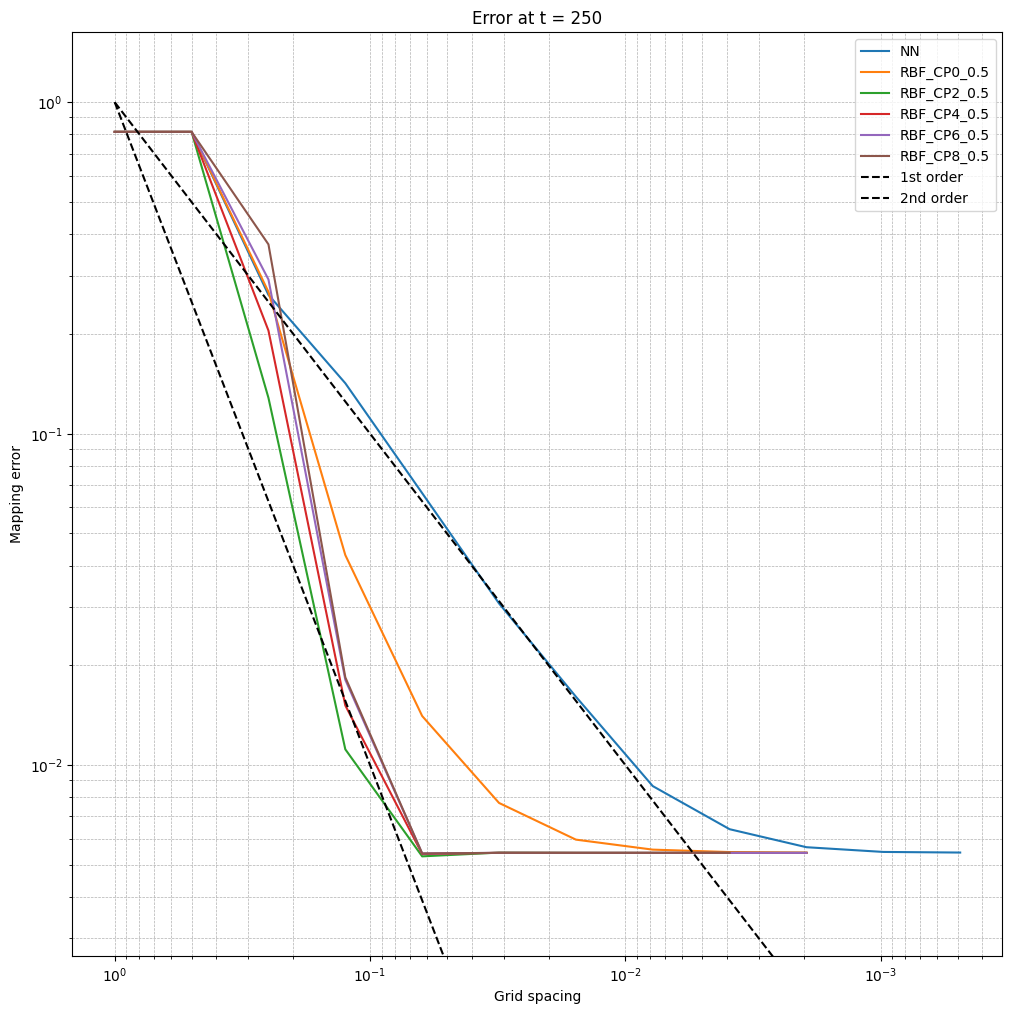

In [3]:
from matplotlib.axes import Axes


def plot_error_convergence(data: pd.DataFrame, title: str, reference_lines = True, ax: Axes = None):
    """Plot the velocity error at a given timestep over different grid resolutions.
    
    Args:
        fig
        data: A DataFrame containing the error data. The index should be the grid
            resolution. Each column will be plotted as a separate line. 
        title: Title of the plot.
        reference_lines: If True, plot reference lines for first and second order
            convergence.
        ax: The axes to plot on. If None, create a new figure and axes.
    """

    # Create figure and axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 12))

    # Plot the data
    for column in data.columns:
        ax.plot(data.index, data[column], label=column)
    
    # Plot reference lines
    if reference_lines:
        # First order convergence
        ax.plot(data.index, data.index, linestyle="--", color="black", label="1st order")
        # Second order convergence
        ax.plot(data.index, data.index ** 2, linestyle="--", color="black", label="2nd order")

    # Add labels and legend
    ax.set_title(title)
    ax.legend()
    ax.grid(which="both", linestyle="--", linewidth=0.5)

    # Configure axes
    ax.set_xlabel("Grid spacing")
    ax.set_xscale("log")
    ax.invert_xaxis()
    
    ax.set_ylabel("Mapping error")
    ax.set_yscale("log")
    ax.set_ylim(data.min().min() / 2, data.max().max() * 2)

plot_error_convergence(df, "Error at t = 250")


### Troubleshoot error floor

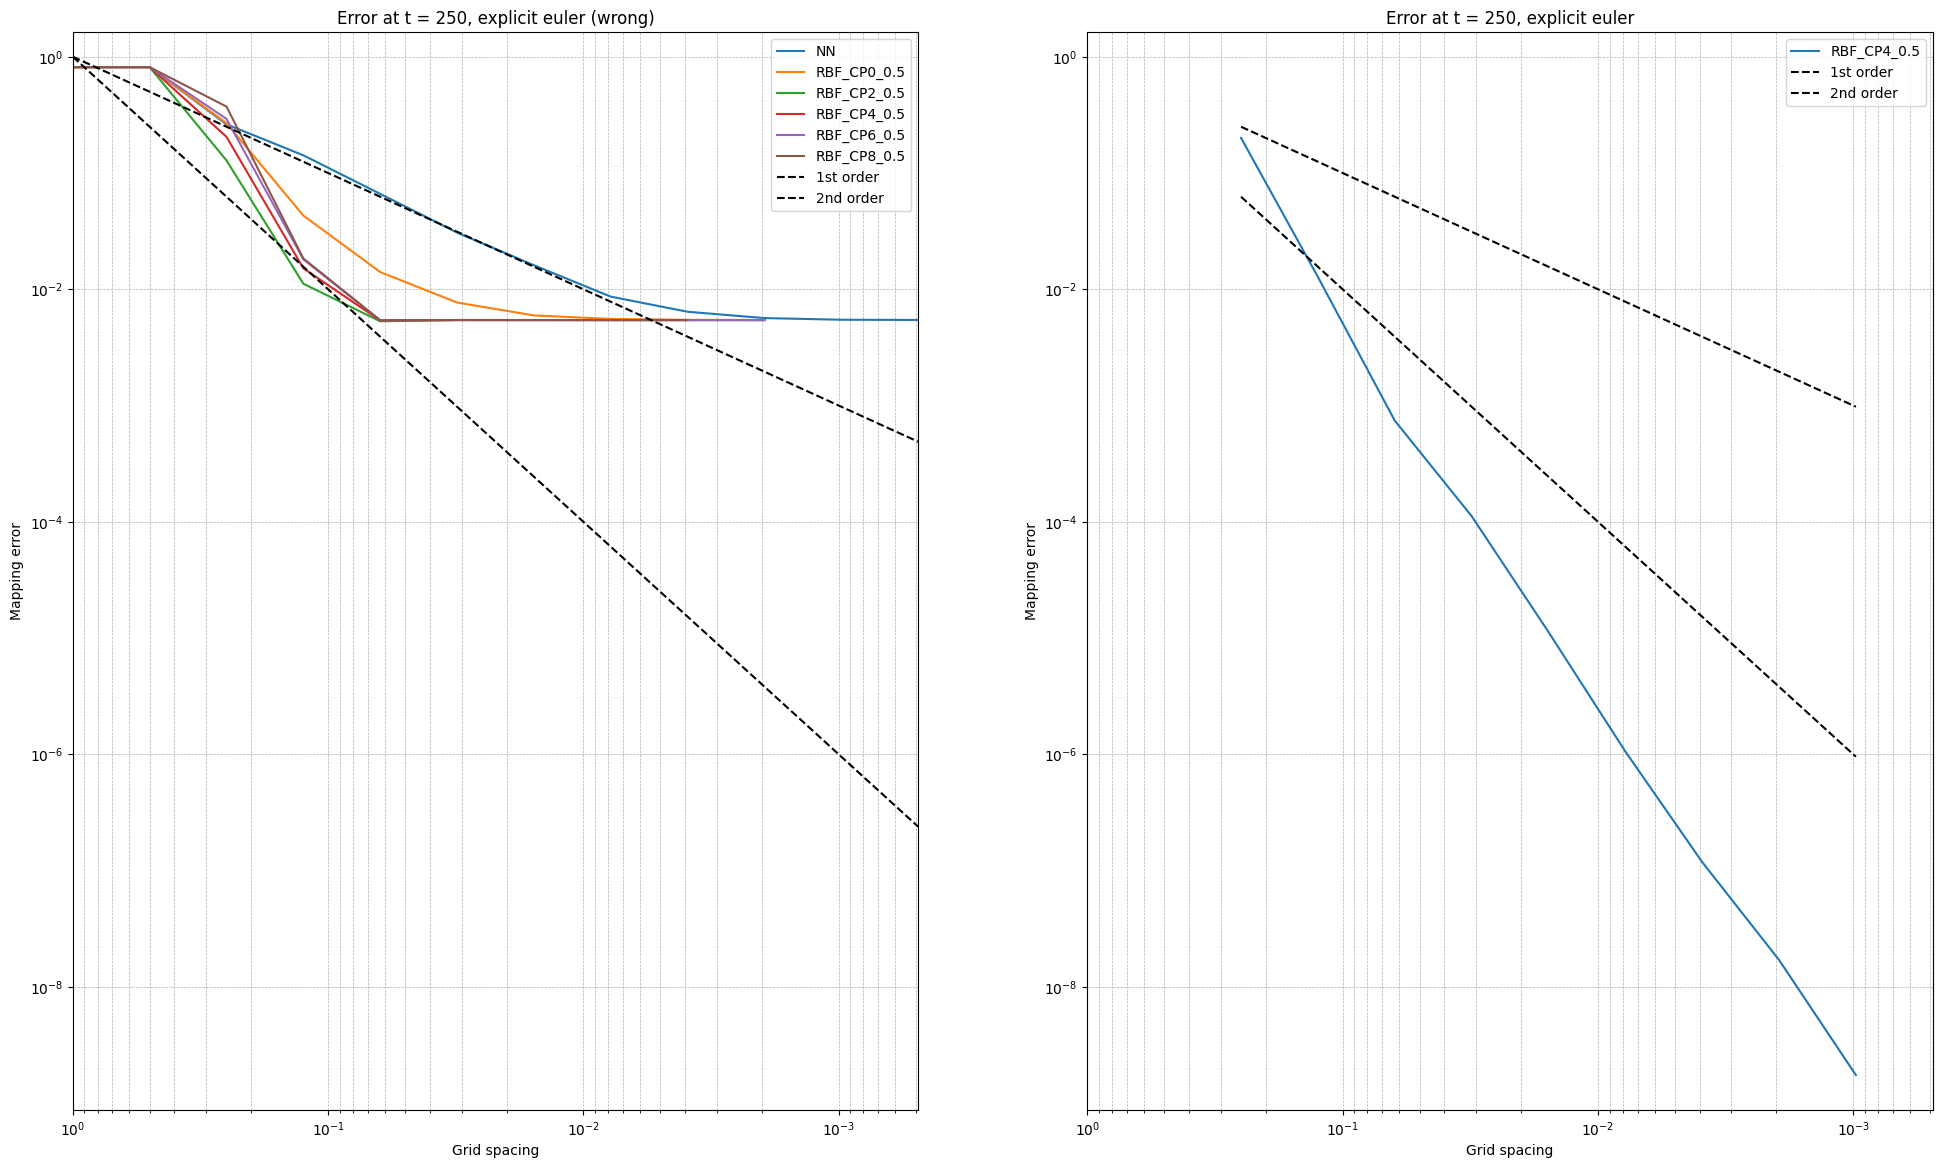

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 14))

timestep = 250

euler_explicit_wrong = load_data(working_dir.parent / "runs" / "euler_explicit_wrong", timestep)
euler_explicit = load_data(working_dir.parent / "runs" / "euler_explicit", timestep)

plot_error_convergence(
    euler_explicit_wrong,
    title="Error at t = 250, explicit euler (wrong)",
    ax=ax[0],
)
plot_error_convergence(
    euler_explicit,
    title="Error at t = 250, explicit euler",
    ax=ax[1],
)

# Calculate global x-axis and y-axis limits across all subplots
x_min = min(data.index.min() for data in [euler_explicit_wrong, euler_explicit])
x_max = max(data.index.max() for data in [euler_explicit_wrong, euler_explicit])
y_min = min(data.min().min() for data in [euler_explicit_wrong, euler_explicit]) / 2
y_max = max(data.max().max() for data in [euler_explicit_wrong, euler_explicit]) * 2

# Set the same x-axis and y-axis limits for all subplots
for subplot in ax:
    subplot.set_xlim(x_max, x_min)
    subplot.set_ylim(y_min, y_max)


In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(24, 14))

timestep = 250

euler_explicit_wrong = load_data(working_dir.parent / "runs" / "euler_explicit_wrong", timestep)
euler_explicit = load_data(working_dir.parent / "runs" / "euler_explicit", timestep)
euler_implicit = load_data(working_dir.parent / "runs" / "euler_implicit", timestep)
trapezoidal = load_data(working_dir.parent / "runs" / "trapezoidal", timestep)

plot_error_convergence(
    euler_explicit_wrong,
    title="Error at t = 250, explicit euler (wrong)",
    ax=ax[0][0],
)
plot_error_convergence(
    euler_explicit,
    title="Error at t = 250, explicit euler",
    ax=ax[0][1],
)
plot_error_convergence(
    euler_implicit,
    title="Error at t = 250, implicit euler",
    ax=ax[0][2],
)
plot_error_convergence(
    trapezoidal,
    title="Error at t = 250, trapezoidal",
    ax=ax[1][1],
)

# Calculate global x-axis and y-axis limits across all subplots
x_min = min(data.index.min() for data in [euler_explicit_wrong, euler_explicit, euler_implicit, trapezoidal])
x_max = max(data.index.max() for data in [euler_explicit_wrong, euler_explicit, euler_implicit, trapezoidal])
y_min = min(data.min().min() for data in [euler_explicit_wrong, euler_explicit, euler_implicit, trapezoidal]) / 2
y_max = max(data.max().max() for data in [euler_explicit_wrong, euler_explicit, euler_implicit, trapezoidal]) * 2

# Set the same x-axis and y-axis limits for all subplots
for row in ax:
    for subplot in row:
        subplot.set_xlim(x_max, x_min)
        subplot.set_ylim(y_min, y_max)
